In [20]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error
root_path = r'/home/woody/iwso/iwso092h/ai_owl/SollIch-Hackathon_Daten/Data_Participants3'
def load_data(root_path, mode='train'):
    data_dict = {}
    if mode == 'train':
        x_folder = "Train_X"
        y_folder = "Train_Y"
    else:
        x_folder = "Eval_X"
        y_folder = "Eval_Y"
    x_files = os.listdir(os.path.join(root_path, x_folder))
    y_files = os.listdir(os.path.join(root_path, y_folder))

    for x_file, y_file in zip(x_files, y_files):
        if x_file.endswith('.pq') and y_file.endswith('.pq'):
            path_X = os.path.join(x_folder, x_file)
            path_Y = os.path.join(y_folder, y_file)
            df_X = pd.read_parquet(os.path.join(root_path, path_X))
            df_X = df_X.drop(['ProzessData_ActData_AB1_Temperature_DS1_WaterPipe'], axis=1)
            df_X = df_X[["ProzessData_ActData_AB1_Temperature_DQ1_MassCoolingStage",
                        "ProzessData_ActData_AB1_Temperature_DX1_MassInfeed",
                        "ProzessData_ActData_AB1_Temperature_DP1_WaterHeatingStage",
                        "ProzessData_ActData_AB1_Temperature_DQ1_WaterCoolingStage",
                        "ProzessData_ActData_AB1_Speed_DV1_Scraper",
                        'ProzessData_ActData_AB1_Temperature_DR1_WaterMixingStage']]
            df_Y = pd.read_parquet(os.path.join(root_path, path_Y))
            # target_col_1 = df_X['ProzessData_ActData_AB1_Temperature_DR1_WaterMixingStage']
            targets = df_Y
            # df_X = df_X.drop(['ProzessData_ActData_AB1_Temperature_DR1_WaterMixingStage'], axis=1)
            date = x_file.split('_')[1:]  # Extracting month and day
            date_key = '_'.join(date)[:5]  # Creating the 'MM_DD' format
            data_dict[date_key] = {'features': df_X, 'targets': targets}

    return data_dict

train_data = load_data(root_path)
val_data = load_data(root_path, mode='val')
def custom_weighted_error(true_values, predicted_values):
    absolute_errors = np.abs(true_values - predicted_values)
    
    points = 0
    for error in absolute_errors:
        if error <= 0.05:
            points += 1
        elif 0.05 < error <= 0.1:
            points += 0.5
        elif 0.1 < error <= 0.5:
            points += 0.25
        else:
            points += 0
    
    return points 

def custom_weighted_error_xgb(preds, dtrain):
    true_values = dtrain.get_label()
    
    absolute_errors = np.abs(true_values - preds)
    
    points = 0
    for error in absolute_errors:
        if error <= 0.05:
            points += 1
        elif 0.05 < error <= 0.1:
            points += 0.5
        elif 0.1 < error <= 0.5:
            points += 0.25
        else:
            points += 0
    
    return 'custom_weighted_error', points / len(preds) * 100

def custom_error_duration(preds, dtrain):
    true_values = dtrain.get_label()
    
    preds_array = preds.astype(float)
    
    absolute_errors = np.abs(true_values - preds_array)
    
    error_less_than_01 = np.sum(absolute_errors < 0.1) / len(absolute_errors)
    
    error_intervals = []
    current_interval = 0
    for error in absolute_errors:
        if error > 0.1:
            current_interval += 1
        else:
            if current_interval > 0:
                error_intervals.append(current_interval)
                current_interval = 0
    
    max_intervals_1 = len(absolute_errors) / 2
    max_intervals_2 = len(absolute_errors) / 8
    
    points = 0
    for interval in error_intervals:
        if interval <= 1:
            points += max(0, 0.5 - (interval / max_intervals_1))
        elif 2 <= interval <= 10:
            points += max(0, 0.25 - (interval / max_intervals_2))
    
    # Calculate the error duration metric
    error_duration_points = (1 - error_less_than_01) * 100 + points
    
    return 'custom_error_duration', error_duration_points 
def add_time_columns(df):
    df['Hour'] = df.index.hour
    df['Minute'] = df.index.minute
    df['Second'] = df.index.second
    return df
def create_time_series_windows(data, window_size):
    windows_X = []
    for i in range(len(data) - window_size):
        window = data.iloc[i:i + window_size]

        windows_X.append(window.values.flatten())

    return np.array(windows_X)

In [3]:
sample_train_features_1 = train_data['03_14']['features']
sample_train_targets_1 = train_data['03_14']['targets']
sample_train_features_2 = train_data['03_15']['features']
sample_train_targets_2 = train_data['03_15']['targets']

final_train_feat = pd.concat([sample_train_features_1, sample_train_features_2], axis=0)

final_train_targets = pd.concat([sample_train_targets_1, sample_train_targets_2], axis=0)

sample_val_features = add_time_columns(val_data['03_16']['features'])
sample_val_targets = val_data['03_16']['targets']

In [5]:
final_train_feat.columns

Index(['ProzessData_ActData_AB1_Temperature_DQ1_MassCoolingStage',
       'ProzessData_ActData_AB1_Temperature_DX1_MassInfeed',
       'ProzessData_ActData_AB1_Temperature_DP1_WaterHeatingStage',
       'ProzessData_ActData_AB1_Temperature_DQ1_WaterCoolingStage',
       'ProzessData_ActData_AB1_Speed_DV1_Scraper',
       'ProzessData_ActData_AB1_Temperature_DR1_WaterMixingStage'],
      dtype='object')

In [7]:
train = final_train_feat
train['ds'] = train.index
train['y'] = final_train_targets

In [9]:
train['ds'] = pd.to_datetime(train['ds']).dt.tz_localize(None)

In [30]:
model = Prophet(interval_width=0)
model.add_regressor('ProzessData_ActData_AB1_Temperature_DQ1_MassCoolingStage', standardize=True)
model.add_regressor('ProzessData_ActData_AB1_Temperature_DX1_MassInfeed', standardize=True)
model.fit(train)

18:12:01 - cmdstanpy - INFO - Chain [1] start processing
18:12:35 - cmdstanpy - INFO - Chain [1] done processing


In [36]:
model.params

OrderedDict([('lp__', array([[371747.]])),
             ('k', array([[0.0053266]])),
             ('m', array([[0.803855]])),
             ('delta',
              array([[-0.00373708, -0.00803928,  0.00898088,  0.00157072, -0.0121148 ,
                       0.0286625 , -0.0928404 ,  0.335988  ,  0.143953  , -0.529271  ,
                       0.164179  , -0.0489214 ,  0.0439128 , -0.0257755 , -0.0214908 ,
                      -0.00616125,  0.0417359 , -0.0371742 , -0.00972234,  0.0554285 ,
                      -0.0724172 ,  0.182989  , -1.02511   ,  1.0395    , -0.152015  ]])),
             ('sigma_obs', array([[0.00265391]])),
             ('beta', array([[0.0954066, 0.047164 ]])),
             ('trend',
              array([[0.803855, 0.803855, 0.803855, ..., 0.804476, 0.804476, 0.804476]]))])

In [31]:
test = sample_val_features
test['ds'] = test.index
test['ds'] = pd.to_datetime(test['ds']).dt.tz_localize(None)

In [32]:
forecast = model.predict(test)

In [33]:
custom_weighted_error(sample_val_targets.to_numpy().flatten(), forecast['yhat'].to_numpy()) / len(forecast['yhat'].to_numpy()) * 100

14.646715691291062

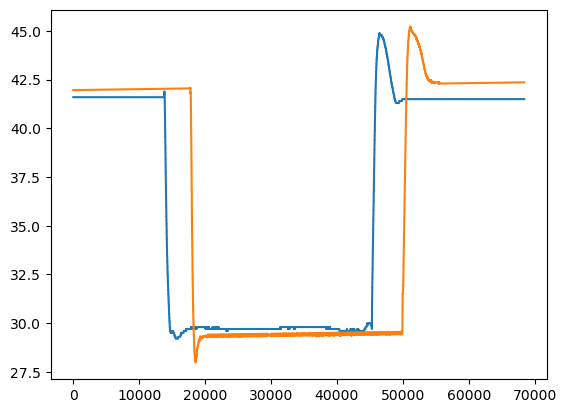

In [35]:
plt.plot(sample_val_targets.to_numpy().flatten())
plt.plot(forecast['yhat'].to_numpy())